In [2]:
import os
path_folder=r'C:\Users\Borsti\Desktop\Thesis\Code\Benessen vs Roemer\rbergomi'
os.chdir(path_folder)

from datetime import datetime, timedelta
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from rbergomi import rBergomi
import pandas as pd
import pickle
import pytz
import scipy
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
#% matplotlib inline

from yahoo_fin.options import get_options_chain, get_expiration_dates

In [3]:
def calculating_expiration(file_name, expiration_dates, loaded_dictionary):
    """Calculating all expirations of option chain in years and 
    combining all information into one DataFrame!"""
    
    # Time of File
    date_str = file_name[17:-4]
    str_format1 = "%Y-%m-%d"
    t_datetime = datetime.strptime(date_str, str_format1)


    df_all_maturities = pd.DataFrame()
    for i, val in enumerate(expiration_dates):

        # Time To Expiration
        str_format2 = "%B %d, %Y"
        exp_datetime = datetime.strptime(val, str_format2)

        # Calculating Time to Expiration in Years
        totsec = (exp_datetime - t_datetime).total_seconds()
        years = totsec / 3600 / 24 / 365
        tau = np.round(years, 3)
        
        # Storing all info in the dataframe
        df_maturity_t = loaded_dictionary[val]["calls"]
        df_maturity_t["Maturity"] = val
        df_maturity_t["Tau"] = tau
        df_all_maturities = pd.concat([df_all_maturities, df_maturity_t])
    return df_all_maturities

In [4]:
def clean_contracts(df):
    df2 = df.copy()
    
    str_format2 = "%B %d, %Y"
    exp_datetime_list = [datetime.strptime(x, str_format2) for x in df2["Maturity"].values]
    
    # calculate needed data
    mid = (df2["Ask"] + df2["Bid"])/2
    spread = df2["Ask"] - df2["Bid"]
    liquidity = spread/mid
    df2["Mid"] = mid
    df2["Spread"] = spread
    df2["Liquidity"] = liquidity
    df2["Keep"] = True

    # Translate reported date into python timestamp
    dt_str_list = [x.split(" ")[0] for x in df2["Last Trade Date"]]
    listasts = pd.DatetimeIndex(dt_str_list)
    df2["Last Trade Date"] = listasts
    df2 = df2.reset_index(drop=True)
    
    # Iterate through the df
    for index, row in df2.iterrows():

        # Identify too old trades/quotes
        date = row["Last Trade Date"]
        lasttrade_delta = (t_datetime - date).days
        if lasttrade_delta >= 1: # if last trade is older than 1 day

            delta_percent = lasttrade_delta/(exp_datetime_list[index] - date).days
            #print("need to check: ", lasttrade_delta)
            #print("delta: ", delta_percent)
            if delta_percent > 0.05:
                keep_var = False
            else:
                keep_var = True

        else:
            keep_var = True
            
        if keep_var == True:
            # Identify illiquid option contracts, for all that have been traded recently
            
            liquidity_i = row["Liquidity"]
            #print(liquidity_i)
            #print("liquidity: ", liquidity_i)
            if liquidity_i > 0.05 or liquidity_i < 0:
                keep_var = False
                #print("Keep?", keep_var)
            else:
                keep_var = True
                
            #print(liquidity_i, keep_var)
        df2.loc[index,"Keep"] = keep_var
        

    df_clean_test = df2
    #display(df_clean_test)

    df_clean_test = df_clean_test[df_clean_test["Keep"]==True]
    #display(df_clean_test) 
    
    cleaned_num = len(df) - len(df_clean_test)
    print("Number of deleted contracts: ", cleaned_num)
    return df_clean_test

In [6]:
# Reading in Data
file_name =  "optionsData_AAPL_2021-06-25.pkl" #"optionsData_AAPL_2021-05-05.pkl"
# Time of File
date_str = file_name[17:-4]
str_format1 = "%Y-%m-%d"
t_datetime = datetime.strptime(date_str, str_format1)

ticker_str = file_name[12:16]
file_to_read = open(file_name, "rb")
loaded_dictionary = pickle.load(file_to_read)
expiration_dates = [key for key in loaded_dictionary]


In [7]:
# Download Discount Rate for black scholes models
import pandas_datareader.data as web
start = datetime(2010, 1, 1)
end = datetime.today()
# DFF = https://fred.stlouisfed.org/series/DFF
# Effective federal funds rate
eff = web.DataReader("DFF", "fred", start, end) # in percent
disc_rate = eff.loc[date_str] * 0.01 # in decimal places

# Defining spot price as of file date
spot = 133.11

In [8]:
# Combining all contracts for all maturities into one df
df_all_maturities = calculating_expiration(file_name, expiration_dates, loaded_dictionary)
# Cleaning the contracts
df_cleaned = clean_contracts(df_all_maturities)

Number of deleted contracts:  464


In [59]:
# select contracts to be used in optimisation
# Here we select the most crucial contracts to reduce optimization time.
# In order to strike a balance, we want to optimize for both the closest 
# and farthest from maturity.  
expiration_dates = df_cleaned["Maturity"].unique()
mid_point = int(np.round(len(expiration_dates)/2))
optimization_slice = expiration_dates[[0, 10, -1]]#, 1, mid_point, -2, -1]]
print("The Dates used for optimization are: ")
print(optimization_slice)

The Dates used for optimization are: 
['July 2, 2021' 'January 21, 2022' 'June 16, 2023']


In [60]:
# Initial rBergomi Parameters
alpha = -0.46
eta = 2
rho = -0.22
xi = 0.323**2
init_params = alpha, eta, rho, xi

def rBergomi_vols(df, params, opt_slice=None):
    #where the fun begins
    alpha, eta, rho, xi = params
    np.random.seed(4)

    if opt_slice is not None:
        df = df[df["Maturity"].isin(opt_slice)]

    exp_dates_list = df["Tau"].unique()
    ST_list = []
    print(datetime.now())
    for i, val in enumerate(exp_dates_list):

        steps_year  = 100
        if val < .1:
            steps_year = 500
            if val < .01:
                steps_year = 10000

        rB = rBergomi(n = steps_year, N = 30000, T = val, a = alpha)
        dW1 = rB.dW1()
        dW2 = rB.dW2()
        Y = rB.Y(dW1)
        dB = rB.dB(dW1, dW2, rho = rho)
        V = rB.V(Y, xi = xi, eta = eta)
        S = rB.S(V, dB)
        ST = S[:,-1][:,np.newaxis]
        ST = ST*spot
        ST_list.append(ST)

    call_prices_list = []
    for i, val in enumerate(exp_dates_list):
        df3 = df[df["Tau"] == val]
        K = df3["Strike"].values
        ST_n = ST_list[i]
        call_payoffs = np.maximum(ST_n - K,0)
        call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
        call_prices_list = [*call_prices_list, *np.squeeze(call_prices)]

    df["Fair Call Prices"] = call_prices_list
    rBerg_vols = vec_bsinv(df["Fair Call Prices"].values, spot, df["Strike"].values, df["Tau"].values, disc_rate)
    print(datetime.now())
    print("---")
    return rBerg_vols


In [77]:
def objective_fun(params):
    rBerg_vols = rBergomi_vols(df_cleaned, params, opt_slice=optimization_slice)
    MSE = np.mean((np.power(np.array(rBerg_vols) - np.array(mid_vols), 2)))
    return MSE
print("Initial MSE: ", objective_fun(Results["x"]))

2021-07-30 02:14:44.530613


<ipython-input-60-c8c5308db2b5>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Fair Call Prices"] = call_prices_list


2021-07-30 02:14:47.004998
---
Initial MSE:  0.04774200724921955


In [78]:
#previous results

# nit=10, success=false
#nm = -0.49790283,  2.1628418 , -0.24869775,  0.07773733
#rBergomi_vols(df_cleaned, nm, opt_slice=optimization_slice)

# nit=50, success=false, MSE=0.034470581415432584
#nm = np.array([-0.49999714,  2.10796278, -0.25204898,  0.07998895])
#vols = rBergomi_vols(df_cleaned, nm, opt_slice=optimization_slice)


#Iterations: 56, Function evaluations: 106, MSE: 0.034471, success=true
#nm = np.array([-0.49999714,  2.10796278, -0.25204898,  0.07998895])
#vols = rBergomi_vols(df_cleaned, nm, opt_slice=optimization_slice)
          
# nit: 111, nfev: 198, MSE: 0.034470581415432584, success: True
#nm = np.array([-0.4969079 ,  3.3928331 ,  0.66223065,  0.12608223])
#vols = rBergomi_vols(df_cleaned, nm, opt_slice=optimization_slice)

# nit: 150, nfev: 286, fun: 0.000877369487961789, success: True # for expiration[0]
#nm = np.array([-0.49966981,  3.74496311, -0.7868674 ,  0.07389432])
#vols = rBergomi_vols(df_cleaned, nm, opt_slice=optimization_slice)

                   
#nit: 69, nfev: 135, fun: 0.10615151141096842,  success: True # for expiration[0,-1]
#nm = np.array([-0.49999914,  2.29577022, -0.23310865,  0.0927153 ])
#vols = rBergomi_vols(df_cleaned, nm, opt_slice=optimization_slice)

#nit: 136, nfev: 237, fun: 0.0011654855515071836, success: True # for expiration[0,-1]
#nm = np.array([-0.49889276,  2.39571788, -0.61381838,  0.08329585])
#vols = rBergomi_vols(df_cleaned, nm, opt_slice=optimization_slice)
        
#nit: 96, nfev: 186, fun: 0.04774200724921955,  success: True # for expiration[0,10, -1]
nm = np.array([-0.5       ,  2.17332443, -0.20813459,  0.09349421])
vols = rBergomi_vols(df_cleaned, Results["x"], opt_slice=optimization_slice)

2021-07-30 02:15:01.930792


<ipython-input-60-c8c5308db2b5>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Fair Call Prices"] = call_prices_list


2021-07-30 02:15:04.446175
---


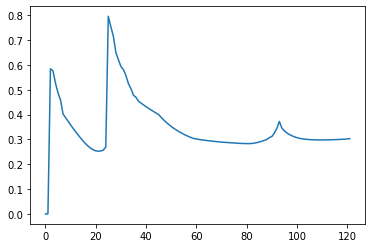

In [79]:
plt.plot(vols)

In [64]:
def BS_mid_vols(df, opt_slice=None):
    if opt_slice is not None:
        df = df[df["Maturity"].isin(opt_slice)]
    mid_vols = vec_bsinv(df["Mid"].values, spot, df["Strike"].values, df["Tau"].values, disc_rate)
    return mid_vols
mid_vols = BS_mid_vols(df_cleaned, opt_slice=optimization_slice)
rBerg_vols = rBergomi_vols(df_cleaned, init_params, opt_slice=optimization_slice)

2021-07-30 01:58:56.003099


<ipython-input-60-c8c5308db2b5>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Fair Call Prices"] = call_prices_list


2021-07-30 01:58:58.555269
---


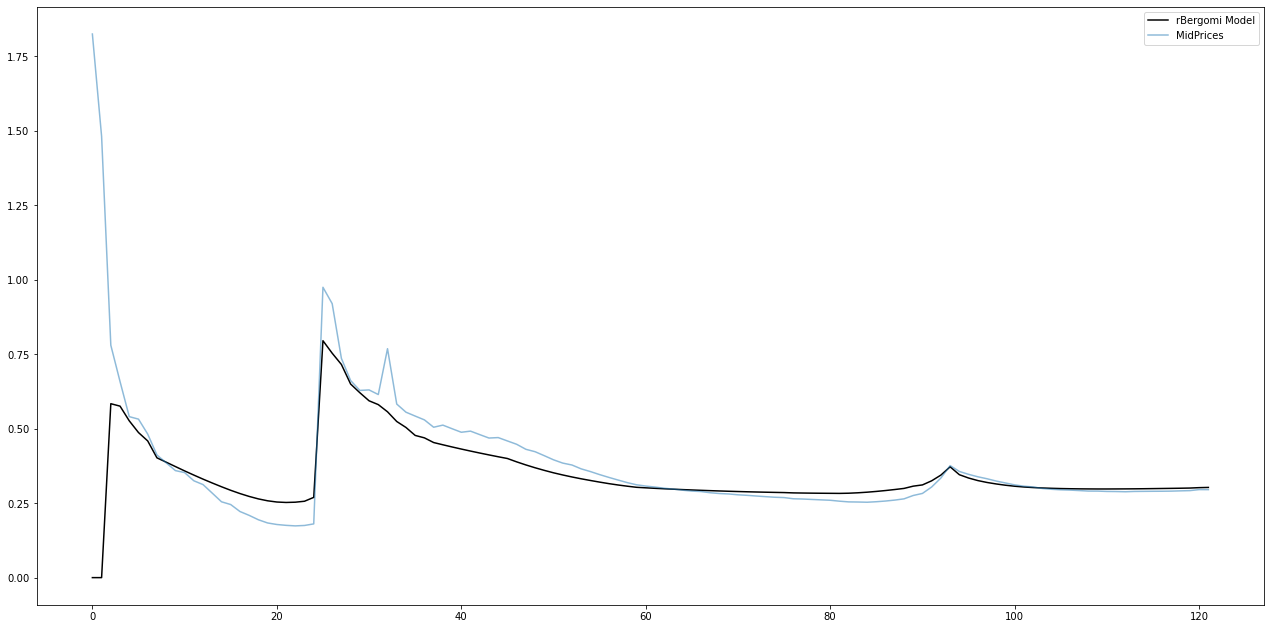

In [80]:
plt.figure(figsize=(22,11))
plt.plot(vols, color="black", label="rBergomi Model")
plt.plot(mid_vols, alpha = 0.5, label="MidPrices")
plt.legend()

In [51]:
init_params = -0.49966981, 3.74496311, -0.7868674, 0.07389432
init_params

(-0.49966981, 3.74496311, -0.7868674, 0.07389432)

In [66]:
Results = scipy.optimize.minimize(objective_fun, x0=init_params, method="Nelder-Mead", bounds=[[-0.0001,1.,-0.05,0.05],[-0.5,5,-1,1]], tol=0.001, options={'maxiter': 500, 'disp': True, 'maxfev': None})

C:\Users\Borsti\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


2021-07-30 01:59:19.270354


<ipython-input-60-c8c5308db2b5>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Fair Call Prices"] = call_prices_list


2021-07-30 01:59:21.834486
---
2021-07-30 01:59:21.858422
2021-07-30 01:59:24.328876
---
2021-07-30 01:59:24.351785
2021-07-30 01:59:26.869012
---
2021-07-30 01:59:26.892948
2021-07-30 01:59:29.441129
---
2021-07-30 01:59:29.464588
2021-07-30 01:59:32.040697
---
2021-07-30 01:59:32.077666
2021-07-30 01:59:34.646721
---
2021-07-30 01:59:34.670657
2021-07-30 01:59:37.387473
---
2021-07-30 01:59:37.410381
2021-07-30 01:59:39.882795
---
2021-07-30 01:59:39.905734
2021-07-30 01:59:42.356180
---
2021-07-30 01:59:42.379124


C:\Users\Borsti\Desktop\Thesis\Code\Benessen vs Roemer\rbergomi\rbergomi.py:31: RuntimeWarning: covariance is not positive-semidefinite.
  return rng(self.e, self.c, (self.N, self.s))
C:\Users\Borsti\Desktop\Thesis\Code\Benessen vs Roemer\rbergomi\rbergomi.py:64: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt(2 * self.a + 1) * (Y1 + Y2)
C:\Users\Borsti\Desktop\Thesis\Code\Benessen vs Roemer\rbergomi\rbergomi.py:89: RuntimeWarning: divide by zero encountered in power
  V = xi * np.exp(eta * Y - 0.5 * eta**2 * t**(2 * a + 1))
C:\Users\Borsti\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


2021-07-30 01:59:45.771030
---
2021-07-30 01:59:45.792982
2021-07-30 01:59:48.214475
---
2021-07-30 01:59:48.236405
2021-07-30 01:59:50.728707
---
2021-07-30 01:59:50.752643
2021-07-30 01:59:54.183111
---
2021-07-30 01:59:54.206023
2021-07-30 01:59:56.652438
---
2021-07-30 01:59:56.675776
2021-07-30 02:00:00.065806
---
2021-07-30 02:00:00.088724
2021-07-30 02:00:02.556143
---
2021-07-30 02:00:02.578503
2021-07-30 02:00:05.112724
---
2021-07-30 02:00:05.135777
2021-07-30 02:00:08.581659
---
2021-07-30 02:00:08.605865
2021-07-30 02:00:12.043633
---
2021-07-30 02:00:12.065541
2021-07-30 02:00:14.500033
---
2021-07-30 02:00:14.521967
2021-07-30 02:00:18.023634
---
2021-07-30 02:00:18.046535
2021-07-30 02:00:20.562801
---
2021-07-30 02:00:20.585740
2021-07-30 02:00:24.133280
---
2021-07-30 02:00:24.156193
2021-07-30 02:00:26.632575
---
2021-07-30 02:00:26.656502
2021-07-30 02:00:30.112253
---
2021-07-30 02:00:30.135172
2021-07-30 02:00:32.581621
---
2021-07-30 02:00:32.603527
2021-07-30 02:

In [76]:
Results["x"]

array([-0.5       ,  2.17332443, -0.20813459,  0.09349421])

In [12]:
Results

 final_simplex: (array([[-0.49966981,  3.74496311, -0.7868674 ,  0.07389432],
       [-0.49966965,  3.7456663 , -0.78711689,  0.07388303],
       [-0.4996698 ,  3.74461094, -0.78679671,  0.07390991],
       [-0.4996696 ,  3.74504843, -0.78706648,  0.07392336],
       [-0.49966959,  3.74561389, -0.78712264,  0.0738884 ]]), array([0.00087737, 0.00087737, 0.00087737, 0.00087737, 0.00087737]))
           fun: 0.000877369487961789
       message: 'Optimization terminated successfully.'
          nfev: 286
           nit: 150
        status: 0
       success: True
             x: array([-0.49966981,  3.74496311, -0.7868674 ,  0.07389432])

In [ ]:
#bounds=[[-0.0001, 1., -0.05, 0.05],[-0.5, 5, -1, 1]]

In [ ]:
#scipy.optimize.minimize(fun, x0, args=(), method='Nelder-Mead', bounds=None, tol=None, callback=None, options={'func': None, 'maxiter': None, 'maxfev': None, 'disp': False, 'return_all': False, 'initial_simplex': None, 'xatol': 0.0001, 'fatol': 0.0001, 'adaptive': False})

2021-07-29 21:11:54.052084
2021-07-29 21:12:04.952946
---


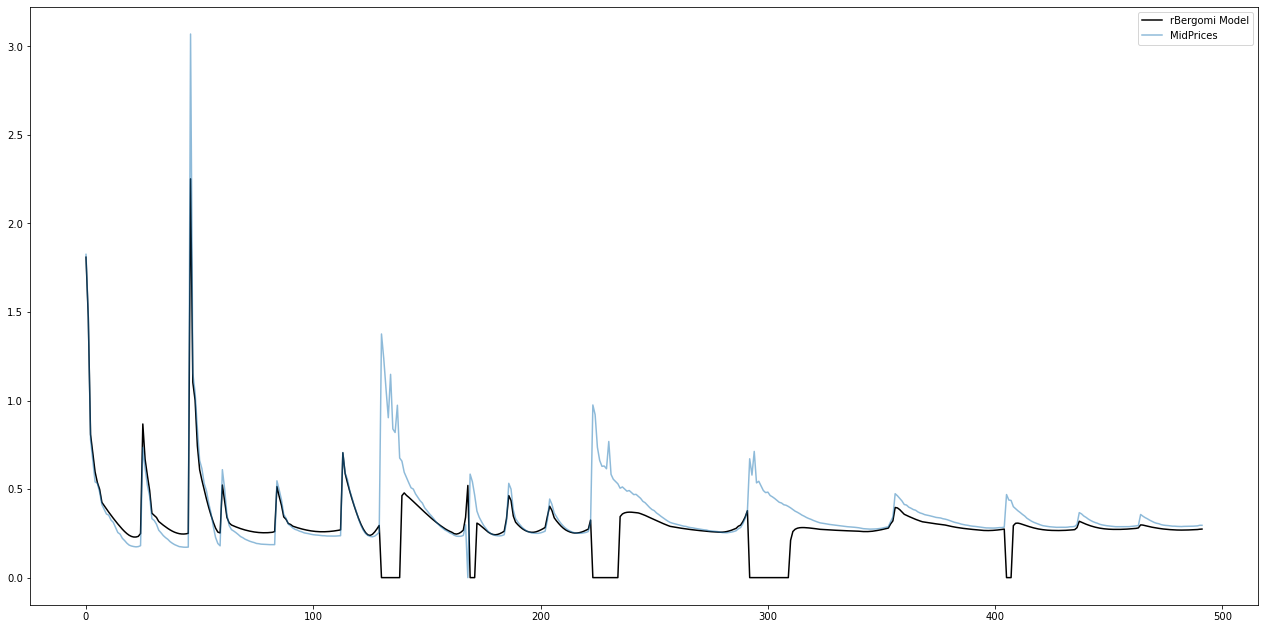

In [58]:
rBerg_vols_full = rBergomi_vols(df_cleaned, nm, opt_slice=None)
mid_vols_full = BS_mid_vols(df_cleaned, opt_slice=None)
plt.figure(figsize=(22,11))
plt.plot(rBerg_vols_full, color="black", label="rBergomi Model")
plt.plot(mid_vols_full, alpha = 0.5, label="MidPrices")
plt.legend()

In [58]:
def funnn(df, spot):
    tauList = df["Tau"].unique()
    df_vol_skew = pd.DataFrame()
    
    for i, val in enumerate(tauList):
        
        df_section = df[df["Tau"]==val]
        strikeList = df_section["Strike"].values
        closest_val = min(strikeList, key=lambda x:abs(x-spot))
        df_strike_slice = df_section[df_section["Strike"] == closest_val]
        df_vol_skew = pd.concat([df_vol_skew, df_strike_slice])
    return df_vol_skew
vol_skew_df = funnn(df_all_maturities, spot=133.11)


In [63]:
df_cleaned

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau,Mid,Spread,Liquidity,Keep
0,AAPL210702C00065000,2021-06-25,65.0,67.85,68.05,68.20,-1.2,-1.74%,8,6,181.25%,"July 2, 2021",0.019,68.125,0.15,0.002202,True
2,AAPL210702C00075000,2021-06-25,75.0,58.00,58.05,58.20,3.9,+7.21%,2,10,146.88%,"July 2, 2021",0.019,58.125,0.15,0.002581,True
7,AAPL210702C00100000,2021-06-25,100.0,32.95,33.05,33.20,-0.7,-2.08%,32,133,77.34%,"July 2, 2021",0.019,33.125,0.15,0.004528,True
8,AAPL210702C00105000,2021-06-25,105.0,28.00,28.05,28.20,-1.12,-3.85%,1,121,65.63%,"July 2, 2021",0.019,28.125,0.15,0.005333,True
13,AAPL210702C00110000,2021-06-25,110.0,23.15,23.05,23.20,0.06,+0.26%,24,66,53.91%,"July 2, 2021",0.019,23.125,0.15,0.006486,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,AAPL230616C00175000,2021-06-25,175.0,9.25,9.10,9.40,-0.22,-2.32%,16,2130,29.26%,"June 16, 2023",1.975,9.250,0.30,0.032432,True
945,AAPL230616C00180000,2021-06-25,180.0,8.35,8.25,8.55,-0.1,-1.18%,91,11194,29.36%,"June 16, 2023",1.975,8.400,0.30,0.035714,True
946,AAPL230616C00185000,2021-06-24,185.0,7.90,7.45,7.80,0,-,59,919,29.48%,"June 16, 2023",1.975,7.625,0.35,0.045902,True
948,AAPL230616C00195000,2021-06-25,195.0,6.27,6.25,6.55,-0.43,-6.42%,8,41253,29.80%,"June 16, 2023",1.975,6.400,0.30,0.046875,True


In [60]:
vol_skew_df

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau
36,AAPL210702C00133000,2021-06-25 3:59PM EDT,133.0,1.36,1.31,1.37,-0.35,-20.47%,21688,10530,17.87%,"July 2, 2021",0.019
27,AAPL210709C00133000,2021-06-25 3:58PM EDT,133.0,1.85,1.82,1.88,-0.33,-15.14%,3939,4764,17.55%,"July 9, 2021",0.038
23,AAPL210716C00135000,2021-06-25 3:59PM EDT,135.0,1.48,1.47,1.51,-0.27,-15.43%,27594,197237,18.19%,"July 16, 2021",0.058
28,AAPL210723C00133000,2021-06-25 3:59PM EDT,133.0,2.89,2.81,2.87,-0.26,-8.25%,1873,3823,19.14%,"July 23, 2021",0.077
23,AAPL210730C00133000,2021-06-25 3:59PM EDT,133.0,4.05,3.95,4.05,-0.25,-5.81%,987,2749,24.30%,"July 30, 2021",0.096
21,AAPL210820C00135000,2021-06-25 3:59PM EDT,135.0,4.00,3.95,4.00,-0.2,-4.76%,11869,53545,23.33%,"August 20, 2021",0.153
50,AAPL210917C00135000,2021-06-25 3:58PM EDT,135.0,5.16,5.05,5.15,-0.14,-2.64%,2378,39509,23.58%,"September 17, 2021",0.230
20,AAPL211015C00135000,2021-06-25 3:55PM EDT,135.0,6.15,6.10,6.20,-0.19,-3.00%,596,9681,23.99%,"October 15, 2021",0.307
14,AAPL211119C00135000,2021-06-25 3:53PM EDT,135.0,7.70,7.60,7.70,-0.15,-1.91%,306,4231,25.40%,"November 19, 2021",0.403
13,AAPL211217C00135000,2021-06-25 3:58PM EDT,135.0,8.55,8.40,8.50,-0.1,-1.16%,314,2721,25.45%,"December 17, 2021",0.479


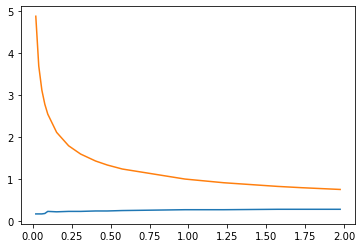

In [67]:
powerlaw=np.power(vol_skew_df["Tau"].values, -0.4)
plt.plot(vol_skew_df["Tau"], yahoo_ivs_list)
plt.plot(vol_skew_df["Tau"], powerlaw)

In [65]:
yahoo_ivs_list=[]
yahoo_ivs = [np.round(float(x[:-1])*0.01,2) for x in vol_skew_df["Implied Volatility"]]
yahoo_ivs_list = [*yahoo_ivs_list, *yahoo_ivs]

In [46]:
df_all_maturities["Tau"].unique()

array([0.019, 0.038, 0.058, 0.077, 0.096, 0.153, 0.23 , 0.307, 0.403,
       0.479, 0.575, 0.978, 1.227, 1.573, 1.726, 1.975])

In [ ]:
(df_all_maturities["Strike"]>=133.11) and (df_all_maturities["Strike"]<=133.11)

In [48]:
df_section = df_all_maturities[df_all_maturities["Tau"]==0.019]

In [51]:
strikeList = df_section["Strike"].values

In [52]:
min(strikeList, key=lambda x:abs(x-133.11))

133.0

In [54]:
df_strike_slice = df_section[df_section["Strike"] == 133.0]

In [56]:
df_vol_skew = pd.DataFrame()
df_vol_skew = pd.concat([df_vol_skew, df_strike_slice])
df_vol_skew

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau
36,AAPL210702C00133000,2021-06-25 3:59PM EDT,133.0,1.36,1.31,1.37,-0.35,-20.47%,21688,10530,17.87%,"July 2, 2021",0.019


In [34]:
df_all_maturities.loc[(df_all_maturities["Strike"] > 133.11-1) & (df_all_maturities["Strike"] < 133.11+1)]

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau
36,AAPL210702C00133000,2021-06-25 3:59PM EDT,133.0,1.36,1.31,1.37,-0.35,-20.47%,21688,10530,17.87%,"July 2, 2021",0.019
37,AAPL210702C00134000,2021-06-25 3:59PM EDT,134.0,0.90,0.86,0.90,-0.31,-25.62%,36852,22899,17.58%,"July 2, 2021",0.019
27,AAPL210709C00133000,2021-06-25 3:58PM EDT,133.0,1.85,1.82,1.88,-0.33,-15.14%,3939,4764,17.55%,"July 9, 2021",0.038
28,AAPL210709C00134000,2021-06-25 3:59PM EDT,134.0,1.40,1.35,1.40,-0.3,-17.65%,7273,14843,17.35%,"July 9, 2021",0.038
28,AAPL210723C00133000,2021-06-25 3:59PM EDT,133.0,2.89,2.81,2.87,-0.26,-8.25%,1873,3823,19.14%,"July 23, 2021",0.077
29,AAPL210723C00134000,2021-06-25 3:58PM EDT,134.0,2.45,2.33,2.39,-0.21,-7.89%,1242,2524,19.06%,"July 23, 2021",0.077
23,AAPL210730C00133000,2021-06-25 3:59PM EDT,133.0,4.05,3.95,4.05,-0.25,-5.81%,987,2749,24.30%,"July 30, 2021",0.096
24,AAPL210730C00134000,2021-06-25 3:59PM EDT,134.0,3.50,3.45,3.55,-0.3,-7.89%,1482,4263,24.12%,"July 30, 2021",0.096


In [41]:
min(my_list, key=lambda x:abs(x-myNumber))

133.0

In [44]:
df_all_maturities[df_all_maturities["Tau"]==0.019]["Strike"].values==133.0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [40]:
my_list = df_all_maturities[df_all_maturities["Tau"]==0.019]["Strike"].values
myNumber=133.11

In [28]:
(df_all_maturities["Strike"]>=133.11) and (df_all_maturities["Strike"]<=133.11)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
(df["B"] > 50) & (df["C"] == 900)

In [19]:
df_all_maturities[df_all_maturities["Strike"]> 133]["Strike"].idxmax()

109